# Objetivos
- Construir ou buscar um dataset contendo imagens de facas, tesouras e
outros objetos cortantes em diferentes condições de ângulo e
iluminação;
- Anotar o dataset para treinar o modelo supervisionado, incluindo
imagens negativas (sem objetos perigosos) para reduzir falsos positivos;
- Treinar o modelo;
- Desenvolver um sistema de alertas (pode ser um e-mail).


# Criacao do nosso container para categorizar as imagens

```docker-compose
services:
  nginx:
    build: .
    image: heartexlabs/label-studio:latest
    restart: unless-stopped
    ports:
      - "8080:8085"
      - "8081:8086"
    depends_on:
      - app
    environment:
      - LABEL_STUDIO_HOST=${LABEL_STUDIO_HOST:-}
    #   Optional: Specify SSL termination certificate & key
    #   Just drop your cert.pem and cert.key into folder 'deploy/nginx/certs'
    #      - NGINX_SSL_CERT=/certs/cert.pem
    #      - NGINX_SSL_CERT_KEY=/certs/cert.key
    volumes:
      - ./mydata:/label-studio/data:rw
      - ./deploy/nginx/certs:/certs:ro
    #   Optional: Override nginx default conf
    #      - ./deploy/my.conf:/etc/nginx/nginx.conf
    command: nginx

  app:
    stdin_open: true
    tty: true
    build: .
    image: heartexlabs/label-studio:latest
    restart: unless-stopped
    expose:
      - "8000"
    depends_on:
      - db
    environment:
      - DJANGO_DB=default
      - POSTGRE_NAME=postgres
      - POSTGRE_USER=postgres
      - POSTGRE_PASSWORD=
      - POSTGRE_PORT=5432
      - POSTGRE_HOST=db
      - LABEL_STUDIO_HOST=${LABEL_STUDIO_HOST:-}
      - JSON_LOG=1
    #      - LOG_LEVEL=DEBUG
    volumes:
      - ./mydata:/label-studio/data:rw
    command: label-studio-uwsgi

  db:
    image: pgautoupgrade/pgautoupgrade:13-alpine
    hostname: db
    restart: unless-stopped
    # Optional: Enable TLS on PostgreSQL
    # Just drop your server.crt and server.key into folder 'deploy/pgsql/certs'
    # NOTE: Both files must have permissions u=rw (0600) or less
    #    command: >
    #      -c ssl=on
    #      -c ssl_cert_file=/var/lib/postgresql/certs/server.crt
    #      -c ssl_key_file=/var/lib/postgresql/certs/server.key
    environment:
      - POSTGRES_HOST_AUTH_METHOD=trust
    volumes:
      - ${POSTGRES_DATA_DIR:-./postgres-data}:/var/lib/postgresql/data
      - ./deploy/pgsql/certs:/var/lib/postgresql/certs:ro

```

# Acessando o site

Para acessar o site na nossa máquina local vamos acessar `http://localhost:8080/` e podemos criar um email fake com uma senha fake.
- Vamos criar um projeto e selecionar como labeling setup o correspondente de detecção de objetos
- Após isso vamos categorizar um a um, sem esquecer de salvar.
- Depois disso vamos salvar exportando como YOLO com Imagens.

Com tudo pronto vamos para a parte do código

# Verificação de GPU

In [41]:
!nvidia-smi

Sun Mar 23 18:57:30 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 4070 ...  WDDM  |   00000000:01:00.0  On |                  N/A |
|  0%   55C    P5             33W /  285W |    3162MiB /  16376MiB |     40%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

# Instalando pacotes necessários

In [2]:
!pip install numpy==2.1.1
!pip install tensorflow==2.9
!pip install --upgrade torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu124

  Obtaining dependency information for numpy==2.1.1 from https://files.pythonhosted.org/packages/e5/6a/b1f7d73fec1942ded4b474a78c3fdd11c4fad5232143f41dd7e6ae166080/numpy-2.1.1-cp310-cp310-win_amd64.whl.metadata
  Using cached numpy-2.1.1-cp310-cp310-win_amd64.whl.metadata (59 kB)
Using cached numpy-2.1.1-cp310-cp310-win_amd64.whl (12.9 MB)



[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


  Obtaining dependency information for tensorflow==2.9 from https://files.pythonhosted.org/packages/10/82/9dad6c25383d4b51551c080641491c1f47fcf44192f8607d68a159ac0056/tensorflow-2.9.0-cp310-cp310-win_amd64.whl.metadata
  Using cached tensorflow-2.9.0-cp310-cp310-win_amd64.whl.metadata (3.0 kB)
  Obtaining dependency information for absl-py>=1.0.0 from https://files.pythonhosted.org/packages/2f/7a/874c46ad2d14998bc2eedac1133c5299e12fe728d2ce91b4d64f2fcc5089/absl_py-2.2.0-py3-none-any.whl.metadata
  Using cached absl_py-2.2.0-py3-none-any.whl.metadata (2.4 kB)
  Obtaining dependency information for astunparse>=1.6.0 from https://files.pythonhosted.org/packages/2b/03/13dde6512ad7b4557eb792fbcf0c653af6076b81e5941d36ec61f7ce6028/astunparse-1.6.3-py2.py3-none-any.whl.metadata
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Obtaining dependency information for flatbuffers<2,>=1.12 from https://files.pythonhosted.org/packages/eb/26/712e578c5f14e26ae3314c39a1bdc4eb2ec2f


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


Looking in indexes: https://download.pytorch.org/whl/cu124
  Obtaining dependency information for torch from https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu124/torch-2.6.0%2Bcu124-cp310-cp310-win_amd64.whl.metadata (28 kB)
  Obtaining dependency information for torchvision from https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu124/torchvision-0.21.0%2Bcu124-cp310-cp310-win_amd64.whl.metadata (6.3 kB)
  Obtaining dependency information for torchaudio from https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp310-cp310-win_amd64.whl.metadata
  Using cached https://download.pytorch.org/whl/cu124/torchaudio-2.6.0%2Bcu124-cp310-cp310-win_amd64.whl.metadata (6.8 kB)
  Obtaining dependency information for filelock from https://download.pytorch.org/whl/filelock-3.13.1-py3-none-any.whl.me


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Separando nossa base em datasets de treino e teste

In [42]:
from pathlib import Path
import random
import sys
import shutil
import os

def train_val_split(datapath, train_pct):
    data_path = datapath
    train_percent = float(train_pct)

    # Verifica se os caminhos existem
    if not os.path.isdir(data_path):
       print('Directory specified by --datapath not found. Verify the path is correct (and uses double back slashes if on Windows) and try again.')
       sys.exit(0)
    if train_percent < .01 or train_percent > 0.99:
       print('Invalid entry for train_pct. Please enter a number between .01 and .99.')
       sys.exit(0)

    # Define a pasta de input do dataset
    input_image_path = os.path.join(data_path,'images')
    input_label_path = os.path.join(data_path,'labels')

    # Define pastas de imagens e anotacoes de labels tanto para treino quanto para teste
    cwd = os.getcwd()
    train_img_path = os.path.join(cwd,'datasets/data/train/images')
    train_txt_path = os.path.join(cwd,'datasets/data/train/labels')
    val_img_path = os.path.join(cwd,'datasets/data/validation/images')
    val_txt_path = os.path.join(cwd,'datasets/data/validation/labels')

    # Cria a pasta caso ela nao exista
    for dir_path in [train_img_path, train_txt_path, val_img_path, val_txt_path]:
       if not os.path.exists(dir_path):
          os.makedirs(dir_path)
          print(f'Pasta criada em {dir_path}.')


    # Recupera a lista de imagens e anotacoes de labels
    img_file_list = [path for path in Path(input_image_path).rglob('*')]
    txt_file_list = [path for path in Path(input_label_path).rglob('*')]

    print(f'Numero de arquivos de imagens: {len(img_file_list)}')
    print(f'Numero de arquivos de labels: {len(txt_file_list)}')

    # Determina o numero de arquivos que vai para treino e teste
    file_num = len(img_file_list)
    train_num = int(file_num*train_percent)
    val_num = file_num - train_num
    print('Imagens que serao movidas para treino: %d' % train_num)
    print('Igmagens que serao movidas para teste: %d' % val_num)

    # Seleciona arquivos randomicamente e envia para treino ou teste sua imagem mais seu txt
    for i, set_num in enumerate([train_num, val_num]):
      for ii in range(set_num):
        img_path = random.choice(img_file_list)
        img_fn = img_path.name
        base_fn = img_path.stem
        txt_fn = base_fn + '.txt'
        txt_path = os.path.join(input_label_path,txt_fn)

        if i == 0: # Faz a copia primeira para treino
          new_img_path, new_txt_path = train_img_path, train_txt_path
        elif i == 1: # depois copia a de teste
          new_img_path, new_txt_path = val_img_path, val_txt_path

        shutil.copy(img_path, os.path.join(new_img_path,img_fn))
        if os.path.exists(txt_path): # Se o txt da imagem nao existir ele pula essa imagem
          shutil.copy(txt_path,os.path.join(new_txt_path,txt_fn))

        img_file_list.remove(img_path)

In [43]:
train_val_split("./custom_data/", 0.9)

Pasta criada em C:\Users\felipe\PycharmProjects\Hackathon\datasets/data/train/images.
Pasta criada em C:\Users\felipe\PycharmProjects\Hackathon\datasets/data/train/labels.
Pasta criada em C:\Users\felipe\PycharmProjects\Hackathon\datasets/data/validation/images.
Pasta criada em C:\Users\felipe\PycharmProjects\Hackathon\datasets/data/validation/labels.
Numero de arquivos de imagens: 341
Numero de arquivos de labels: 341
Imagens que serao movidas para treino: 306
Igmagens que serao movidas para teste: 35


# Instalando o ultralytics

Afinal vamos utilizar o YOLO para as nossas detecções.

In [5]:
!pip install ultralytics

  Obtaining dependency information for ultralytics from https://files.pythonhosted.org/packages/b1/81/33c0360165a0fb73117c86088b5010c08edf07a0007e16ea0ed1e3c83a26/ultralytics-8.3.94-py3-none-any.whl.metadata
  Using cached ultralytics-8.3.94-py3-none-any.whl.metadata (35 kB)
  Obtaining dependency information for matplotlib>=3.3.0 from https://files.pythonhosted.org/packages/b6/1b/025d3e59e8a4281ab463162ad7d072575354a1916aba81b6a11507dfc524/matplotlib-3.10.1-cp310-cp310-win_amd64.whl.metadata
  Using cached matplotlib-3.10.1-cp310-cp310-win_amd64.whl.metadata (11 kB)
  Obtaining dependency information for opencv-python>=4.6.0 from https://files.pythonhosted.org/packages/a4/7d/f1c30a92854540bf789e9cd5dde7ef49bbe63f855b85a2e6b3db8135c591/opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata
  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Obtaining dependency information for scipy>=1.4.1 from https://files.pythonhosted.org/packages/d0/d2/f0683b7e992be4


[notice] A new release of pip is available: 23.2.1 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


# Criação do arquivo data.yml

Nele teremos:
- Caminho dos dados
- Número de classes
- Nome das classes
- Outras configurações

In [44]:
# Python function to automatically create data.yaml config file
# 1. Reads "classes.txt" file to get list of class names
# 2. Creates data dictionary with correct paths to folders, number of classes, and names of classes
# 3. Writes data in YAML format to data.yaml

import yaml
import os

def create_data_yaml(path_to_classes_txt, path_to_data_yaml):

  # Read class.txt to get class names
  if not os.path.exists(path_to_classes_txt):
    print(f'classes.txt file not found! Please create a classes.txt labelmap and move it to {path_to_classes_txt}')
    return
  with open(path_to_classes_txt, 'r') as f:
    classes = []
    for line in f.readlines():
      if len(line.strip()) == 0: continue
      classes.append(line.strip())
  number_of_classes = len(classes)

  # Create data dictionary
  data = {
      'path': 'data',
      'train': 'train/images',
      'val': 'validation/images',
      'nc': number_of_classes,
      'names': classes
  }

  # Write data to YAML file
  with open(path_to_data_yaml, 'w') as f:
    yaml.dump(data, f, sort_keys=False)
  print(f'Created config file at {path_to_data_yaml}')

  return

# Define path to classes.txt and run function
path_to_classes_txt = './custom_data/classes.txt'
path_to_data_yaml = './data.yaml'

create_data_yaml(path_to_classes_txt, path_to_data_yaml)

print('\nFile contents:\n')
!type .\data.yaml

Created config file at ./data.yaml

File contents:

path: data
train: train/images
val: validation/images
nc: 3
names:
- estilete
- faca
- tesoura


# Treinando nosso modelo

In [45]:
!yolo detect train data=./data.yaml model=yolo11s.pt epochs=60 imgsz=640 device=0

New https://pypi.org/project/ultralytics/8.3.95 available ðŸ˜ƒ Update with 'pip install -U ultralytics'
Ultralytics 8.3.94 ðŸš€ Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
engine\trainer: task=detect, mode=train, model=yolo11s.pt, data=./data.yaml, epochs=60, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, 


  0%|          | 0.00/18.4M [00:00<?, ?B/s]
 32%|###1      | 5.88M/18.4M [00:00<00:00, 60.0MB/s]
 71%|#######   | 13.0M/18.4M [00:00<00:00, 68.4MB/s]
100%|##########| 18.4M/18.4M [00:00<00:00, 68.3MB/s]

  0%|          | 0.00/5.35M [00:00<?, ?B/s]
100%|##########| 5.35M/5.35M [00:00<00:00, 61.6MB/s]

train: Scanning C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\train\labels...:   0%|          | 0/306 [00:00<?, ?it/s]
train: Scanning C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\train\labels... 297 images, 17 backgrounds, 0 corrupt:  97%|#########7| 297/306 [00:00<00:00, 2961.80it/s]
train: Scanning C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\train\labels... 306 images, 17 backgrounds, 0 corrupt: 100%|##########| 306/306 [00:00<00:00, 2991.80it/s]

val: Scanning C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\labels...:   0%|          | 0/35 [00:00<?, ?it/s]
val: Scanning C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validati

# Validando nosso modelo

In [46]:
!yolo detect predict model=runs/detect/train/weights/best.pt source=datasets/data/validation/images save=True conf=0.5

Ultralytics 8.3.94 ðŸš€ Python-3.10.11 torch-2.6.0+cu124 CUDA:0 (NVIDIA GeForce RTX 4070 Ti SUPER, 16376MiB)
YOLO11s summary (fused): 100 layers, 9,413,961 parameters, 0 gradients, 21.3 GFLOPs

image 1/35 C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\images\02a0e073-IMG-20250322-WA0166.jpg: 640x480 1 estilete, 54.8ms
image 2/35 C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\images\0bbba8a7-IMG-20250322-WA0189.jpg: 640x480 1 faca, 7.4ms
image 3/35 C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\images\10ad14f4-IMG-20250322-WA0153.jpg: 640x480 1 faca, 7.1ms
image 4/35 C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\images\1cdbdf72-IMG-20250322-WA0151.jpg: 640x480 1 tesoura, 6.9ms
image 5/35 C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\images\1ec90b1a-IMG-20250322-WA0095.jpg: 640x480 1 faca, 6.9ms
image 6/35 C:\Users\felipe\PycharmProjects\Hackathon\datasets\data\validation\images\1f1fe1cc

# Demonstrando detecções com nosso modelo

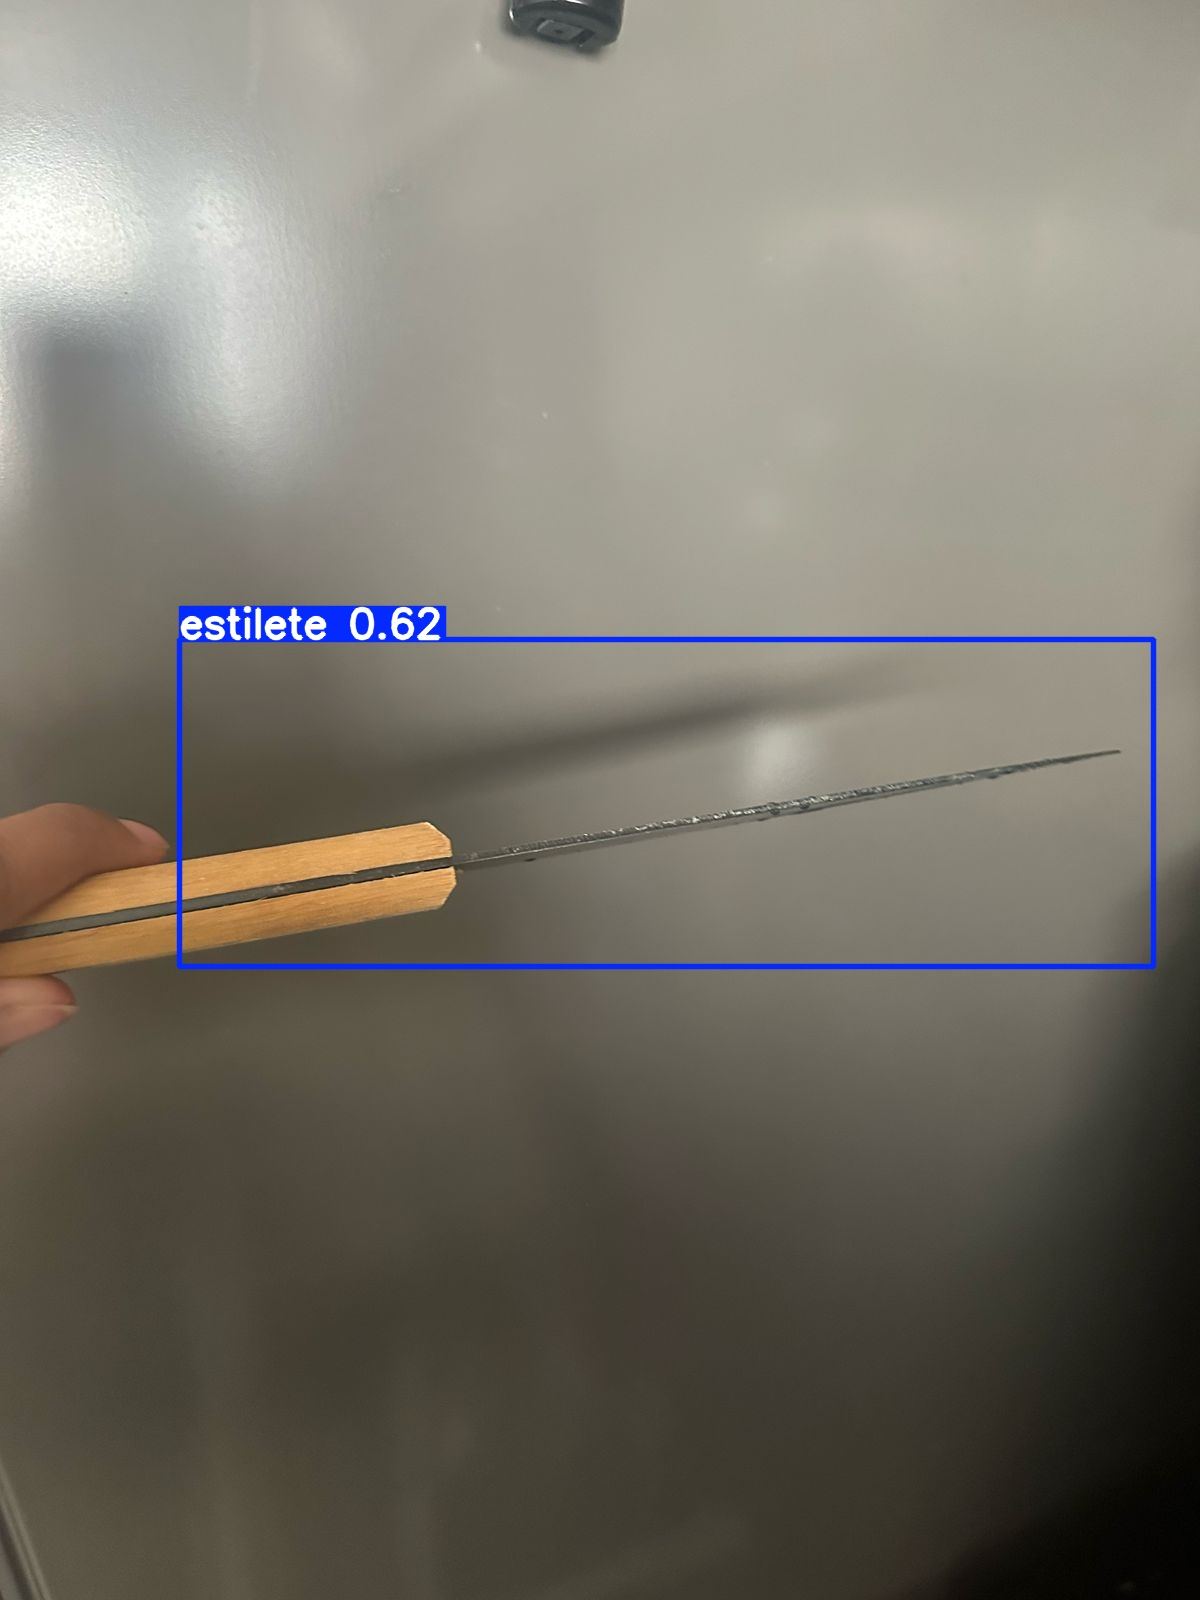

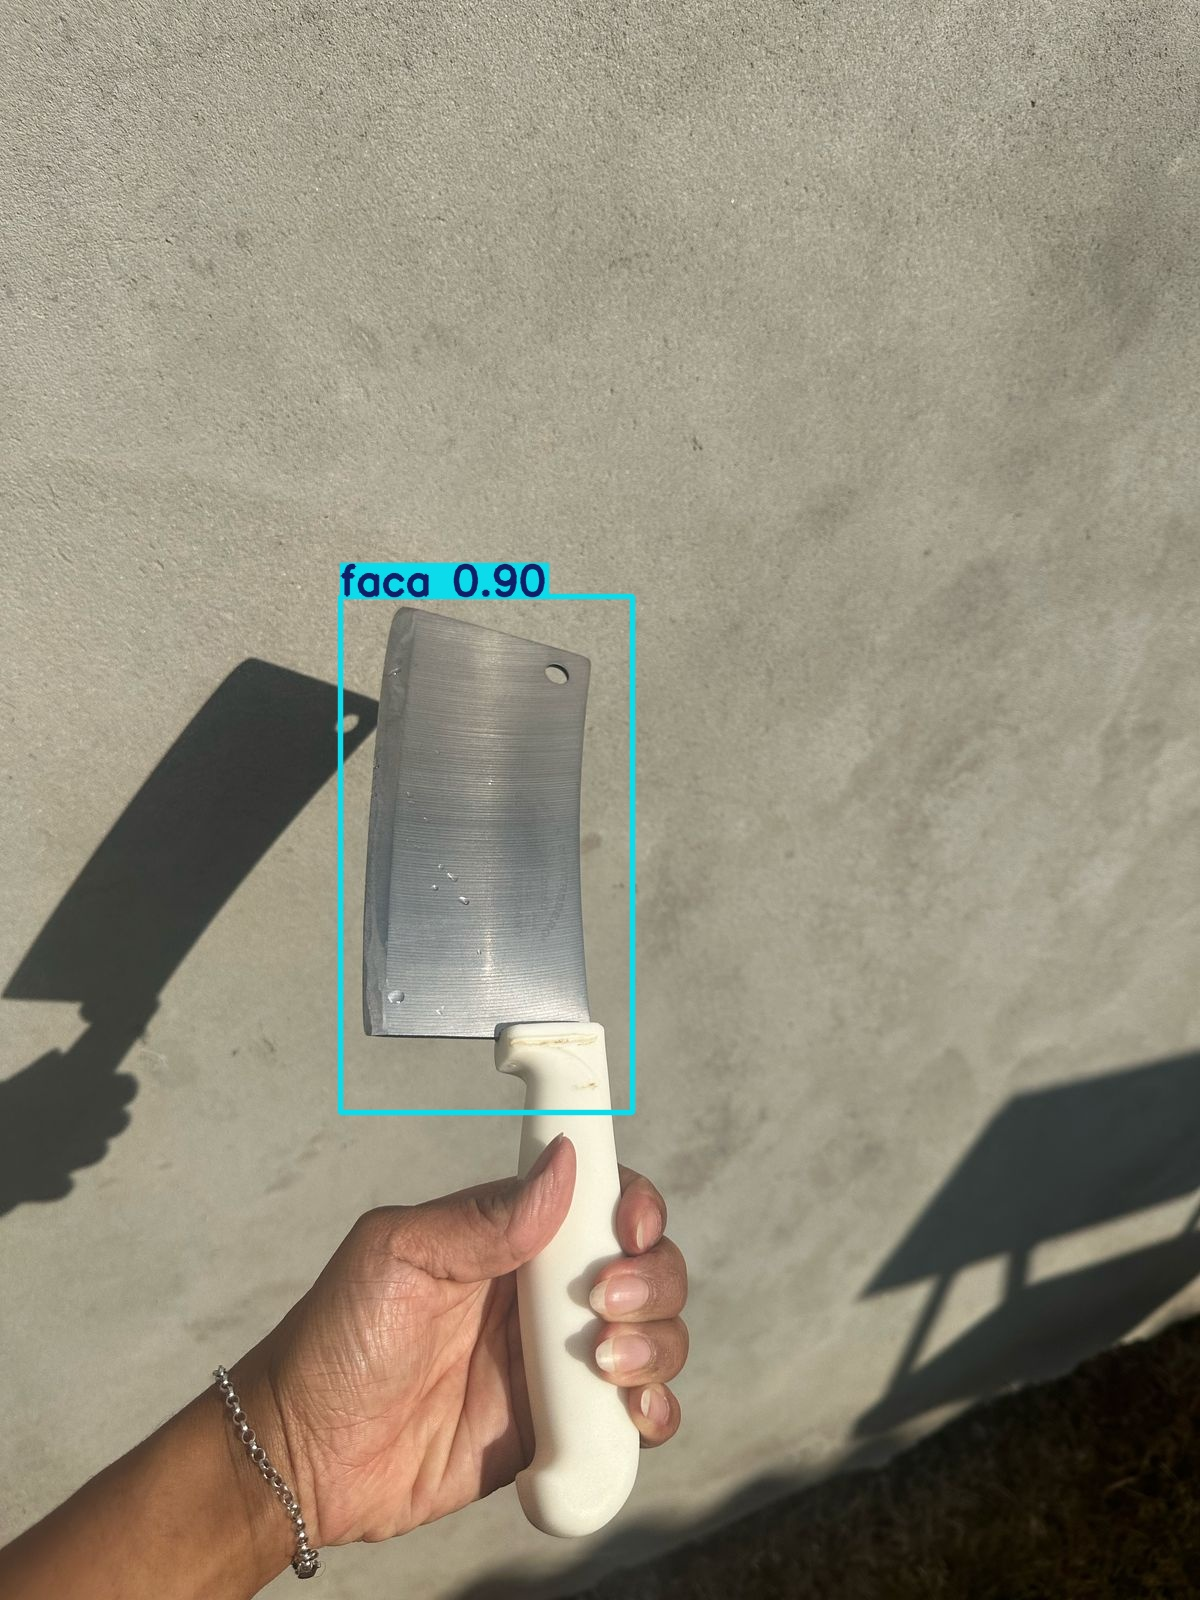

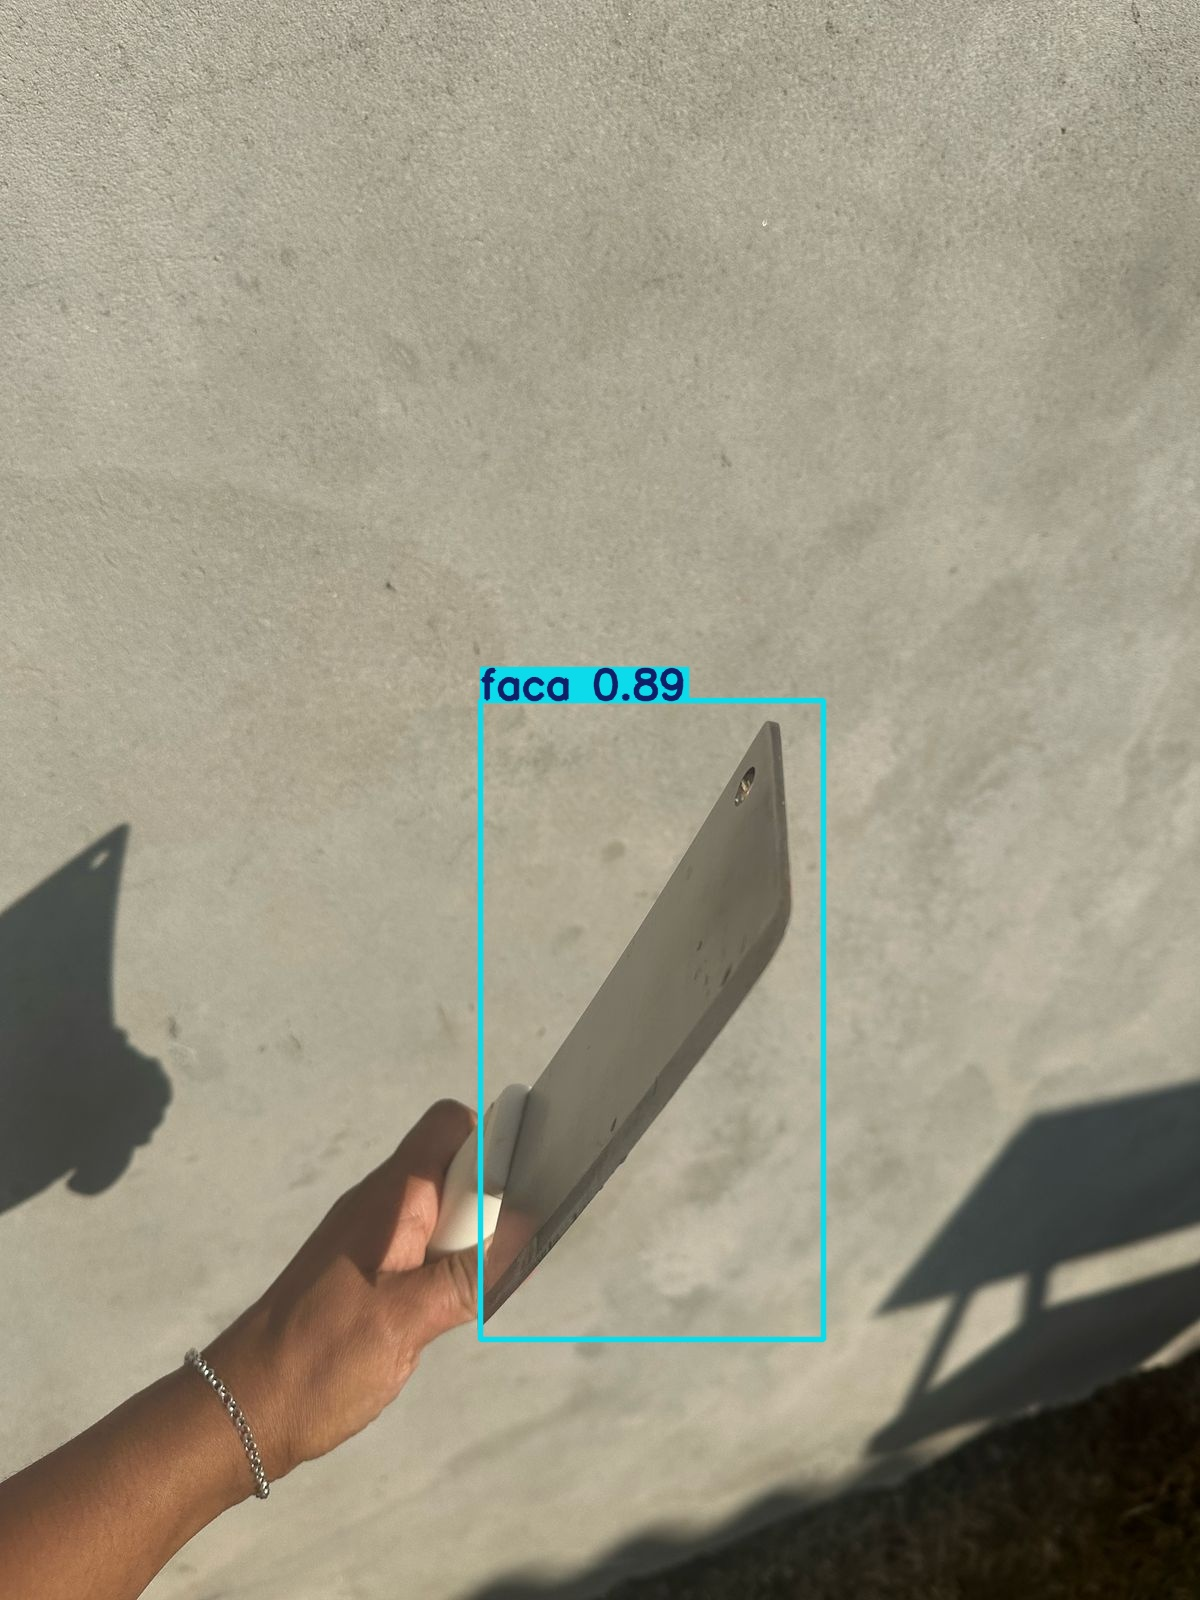

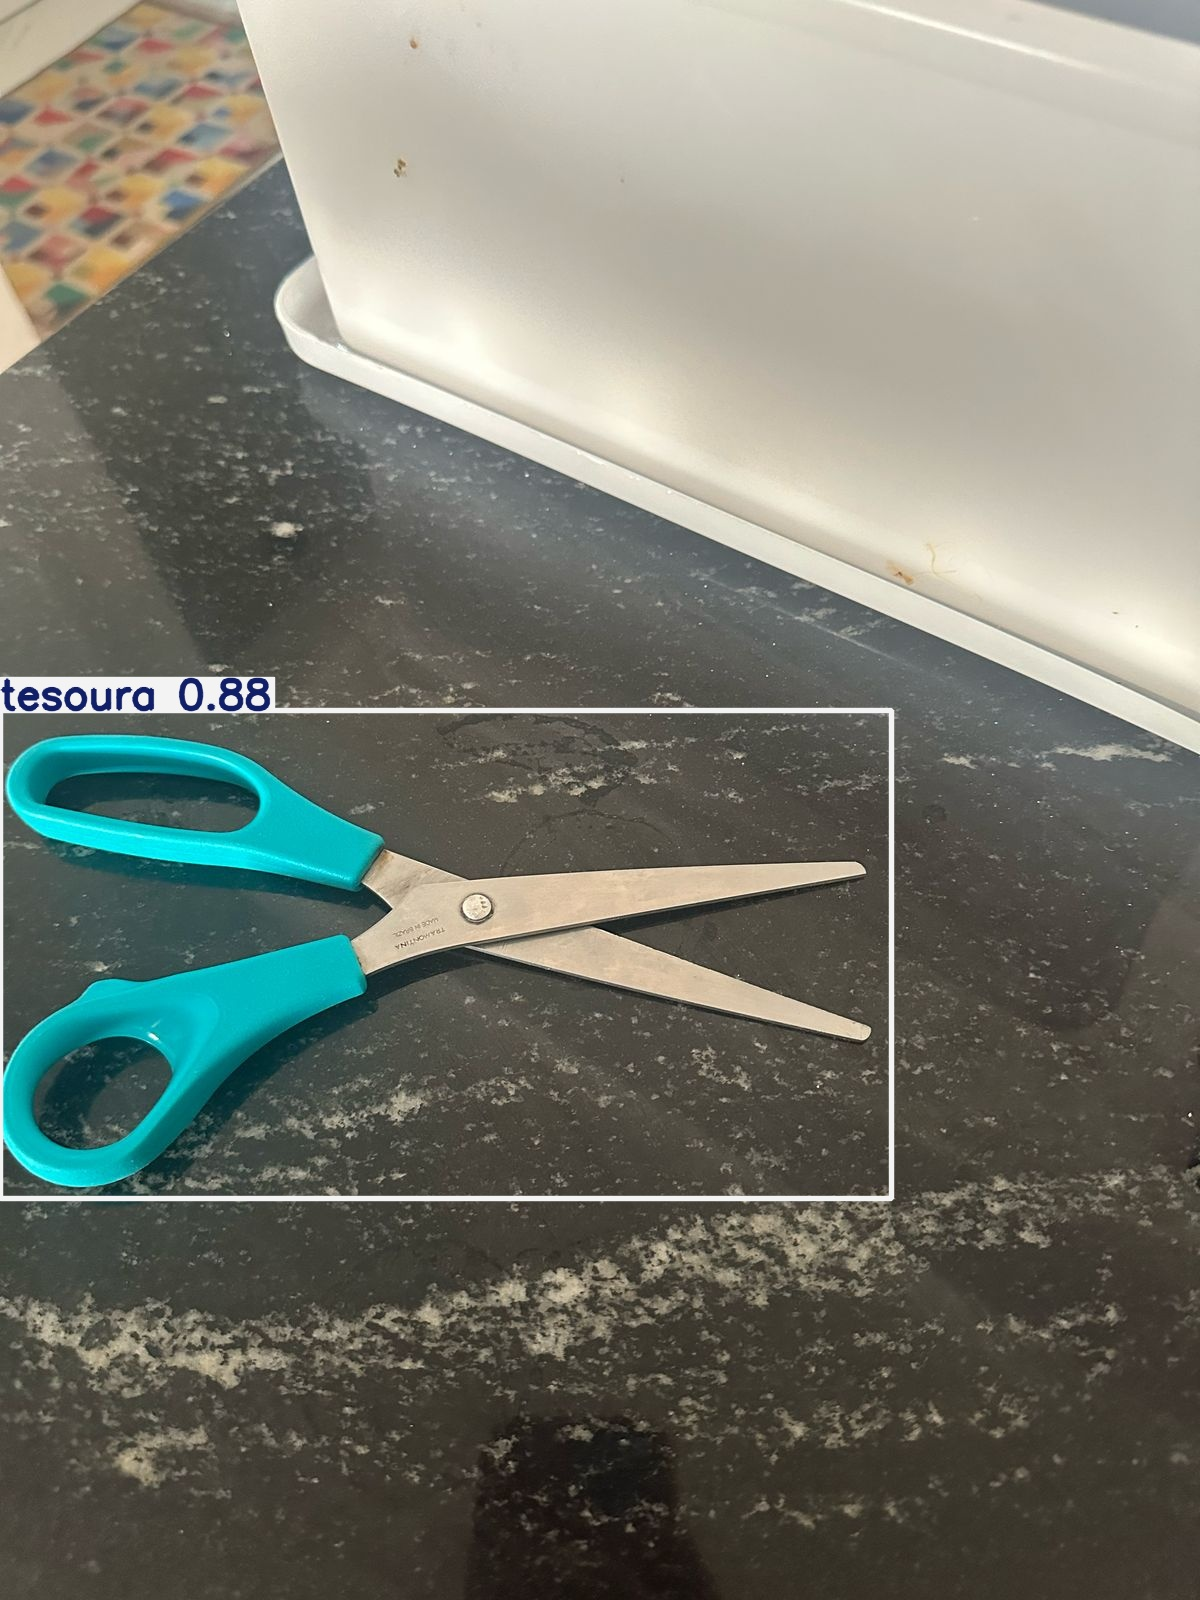

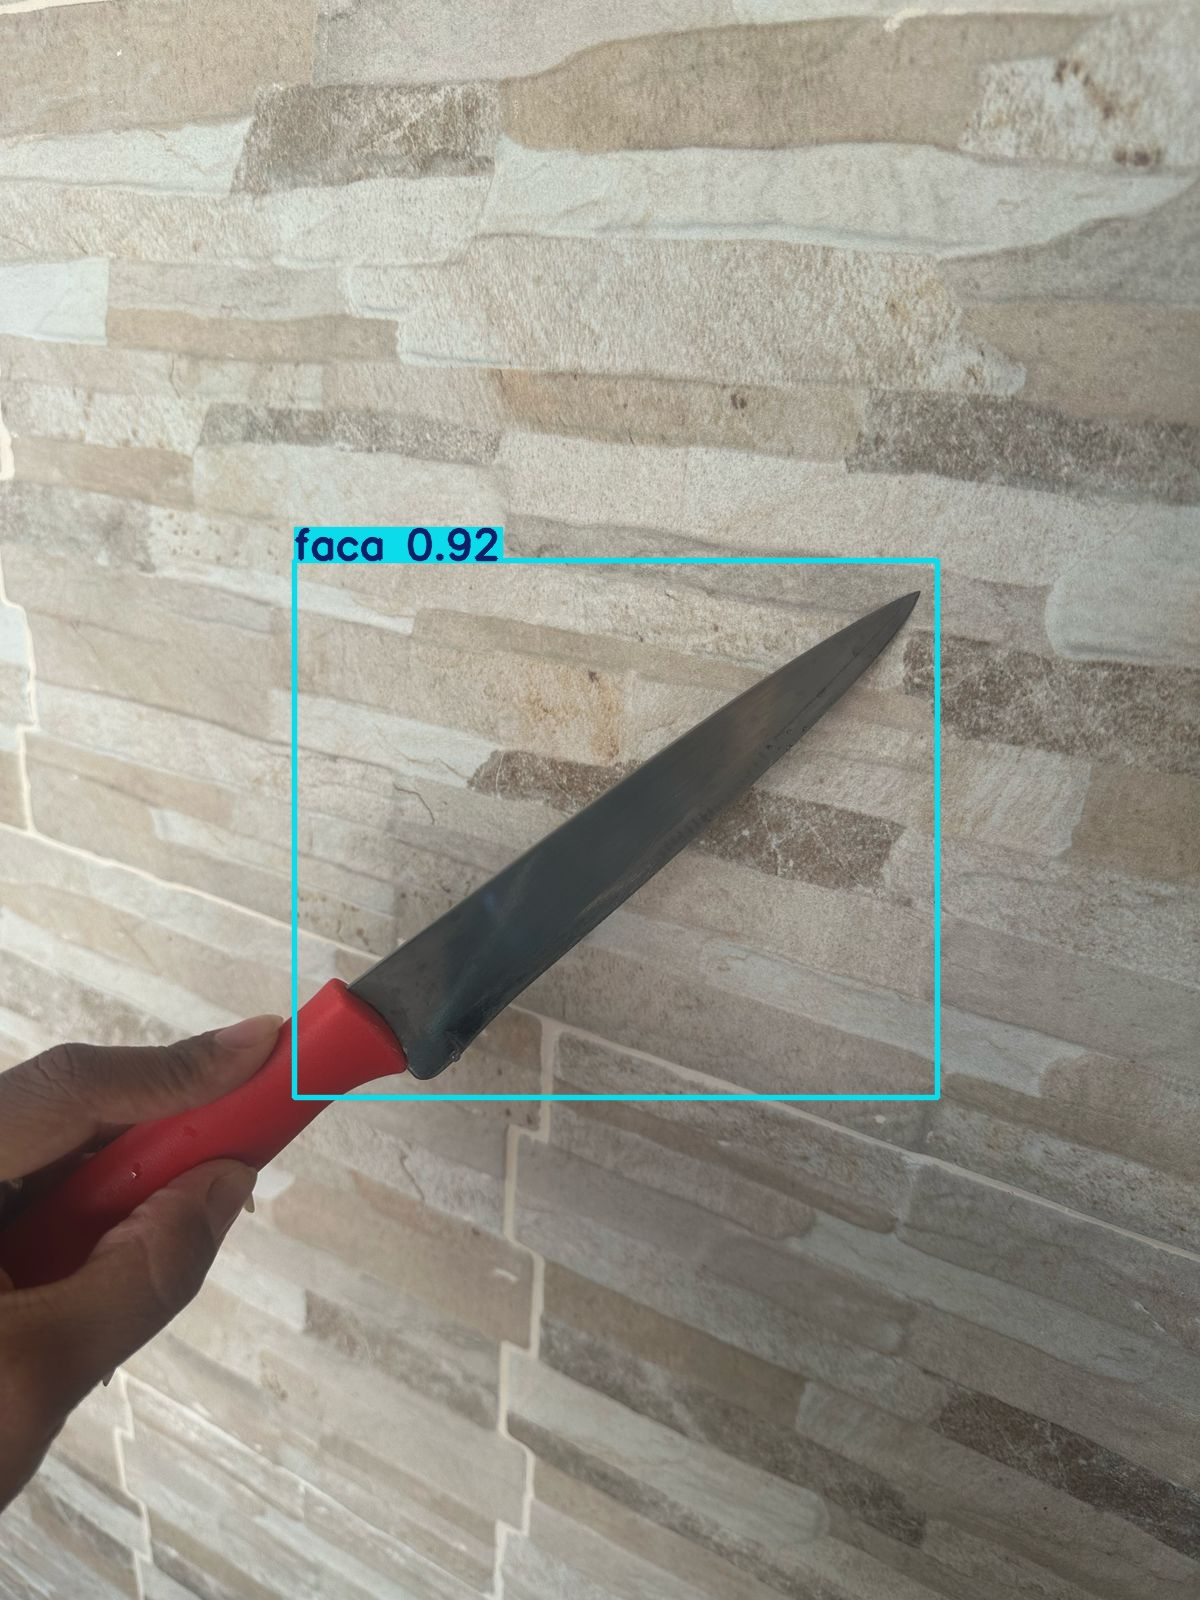

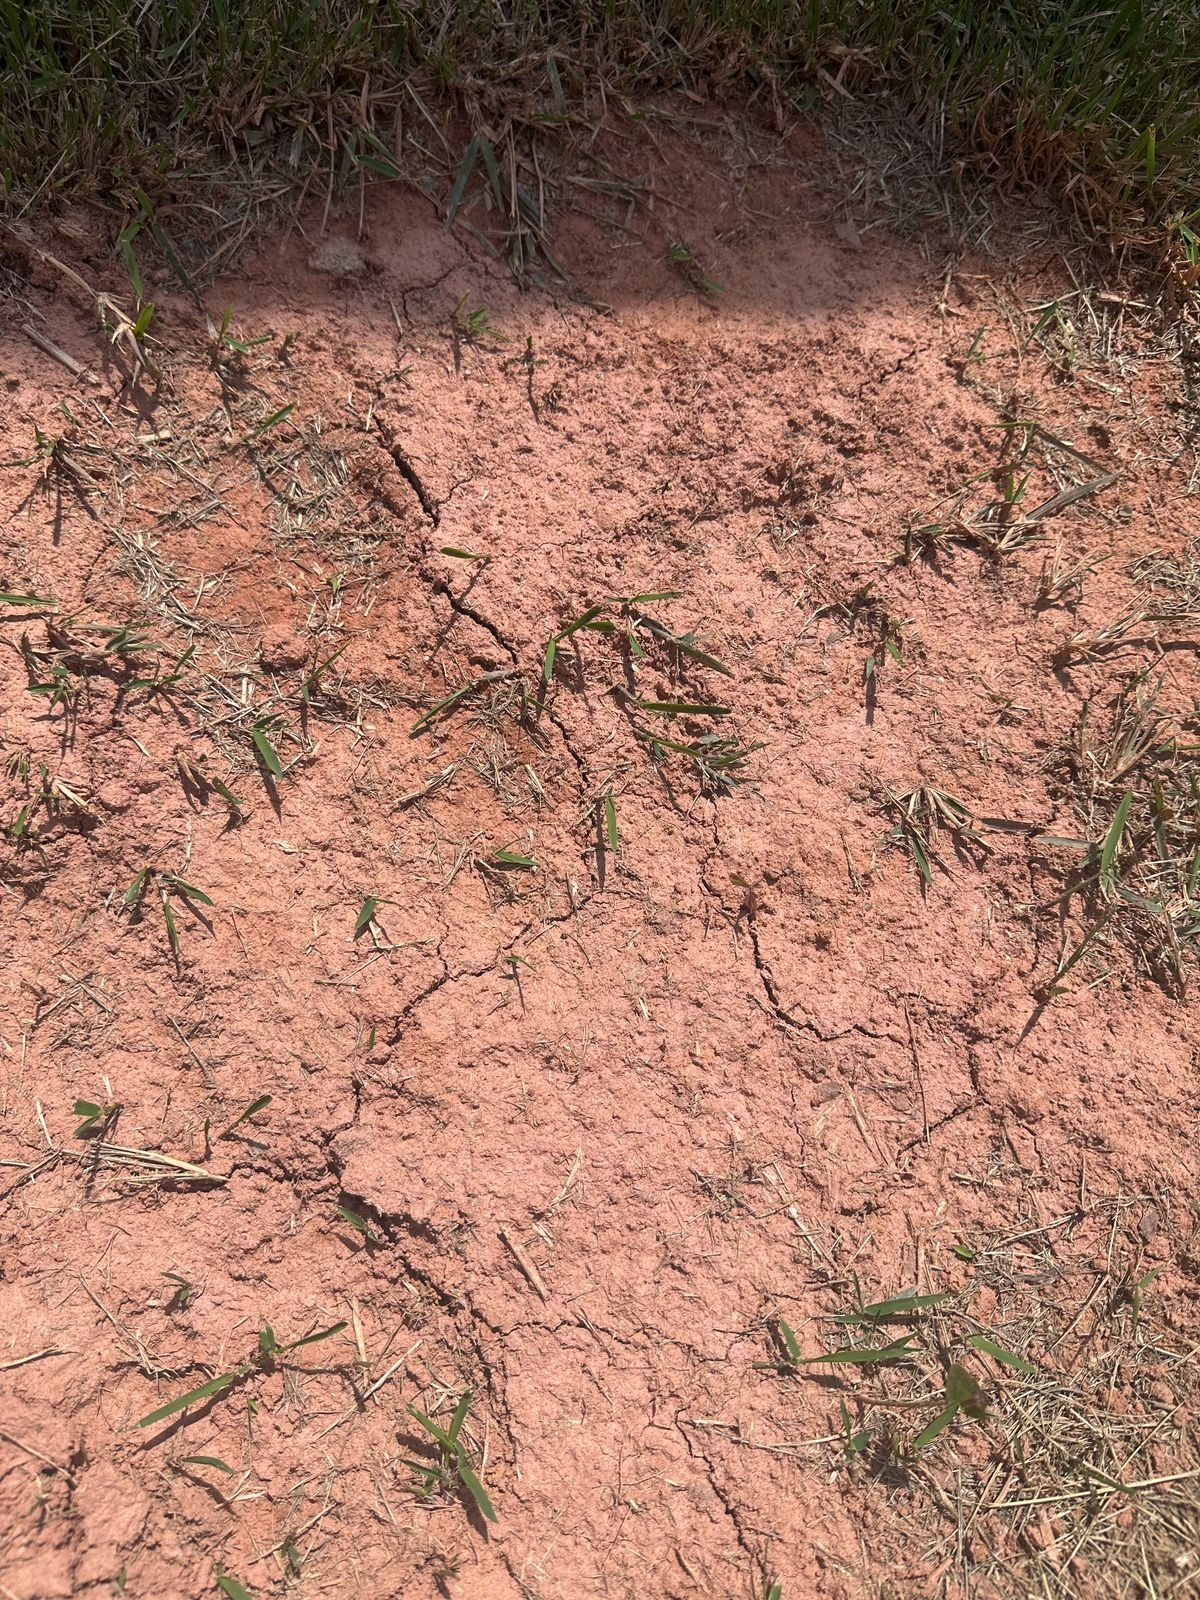

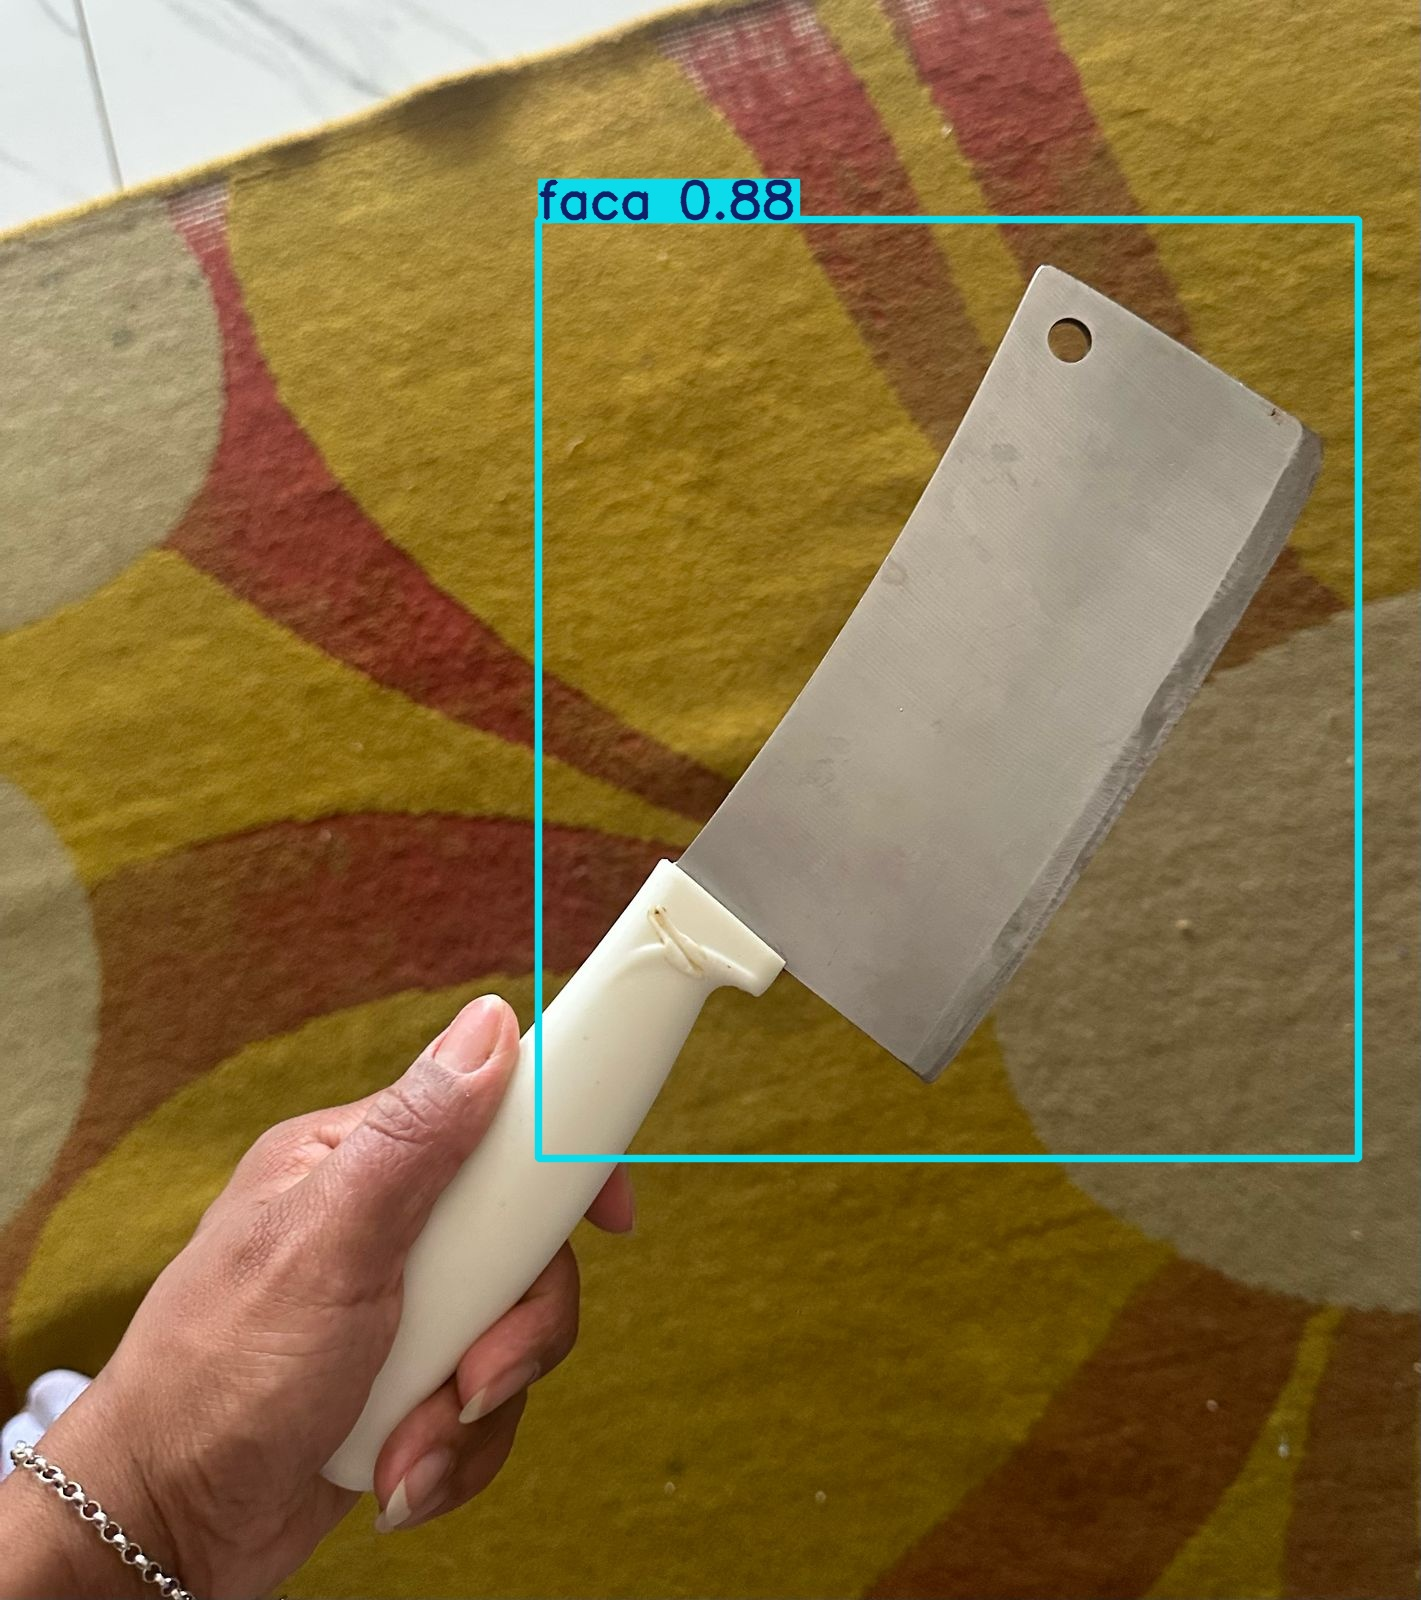

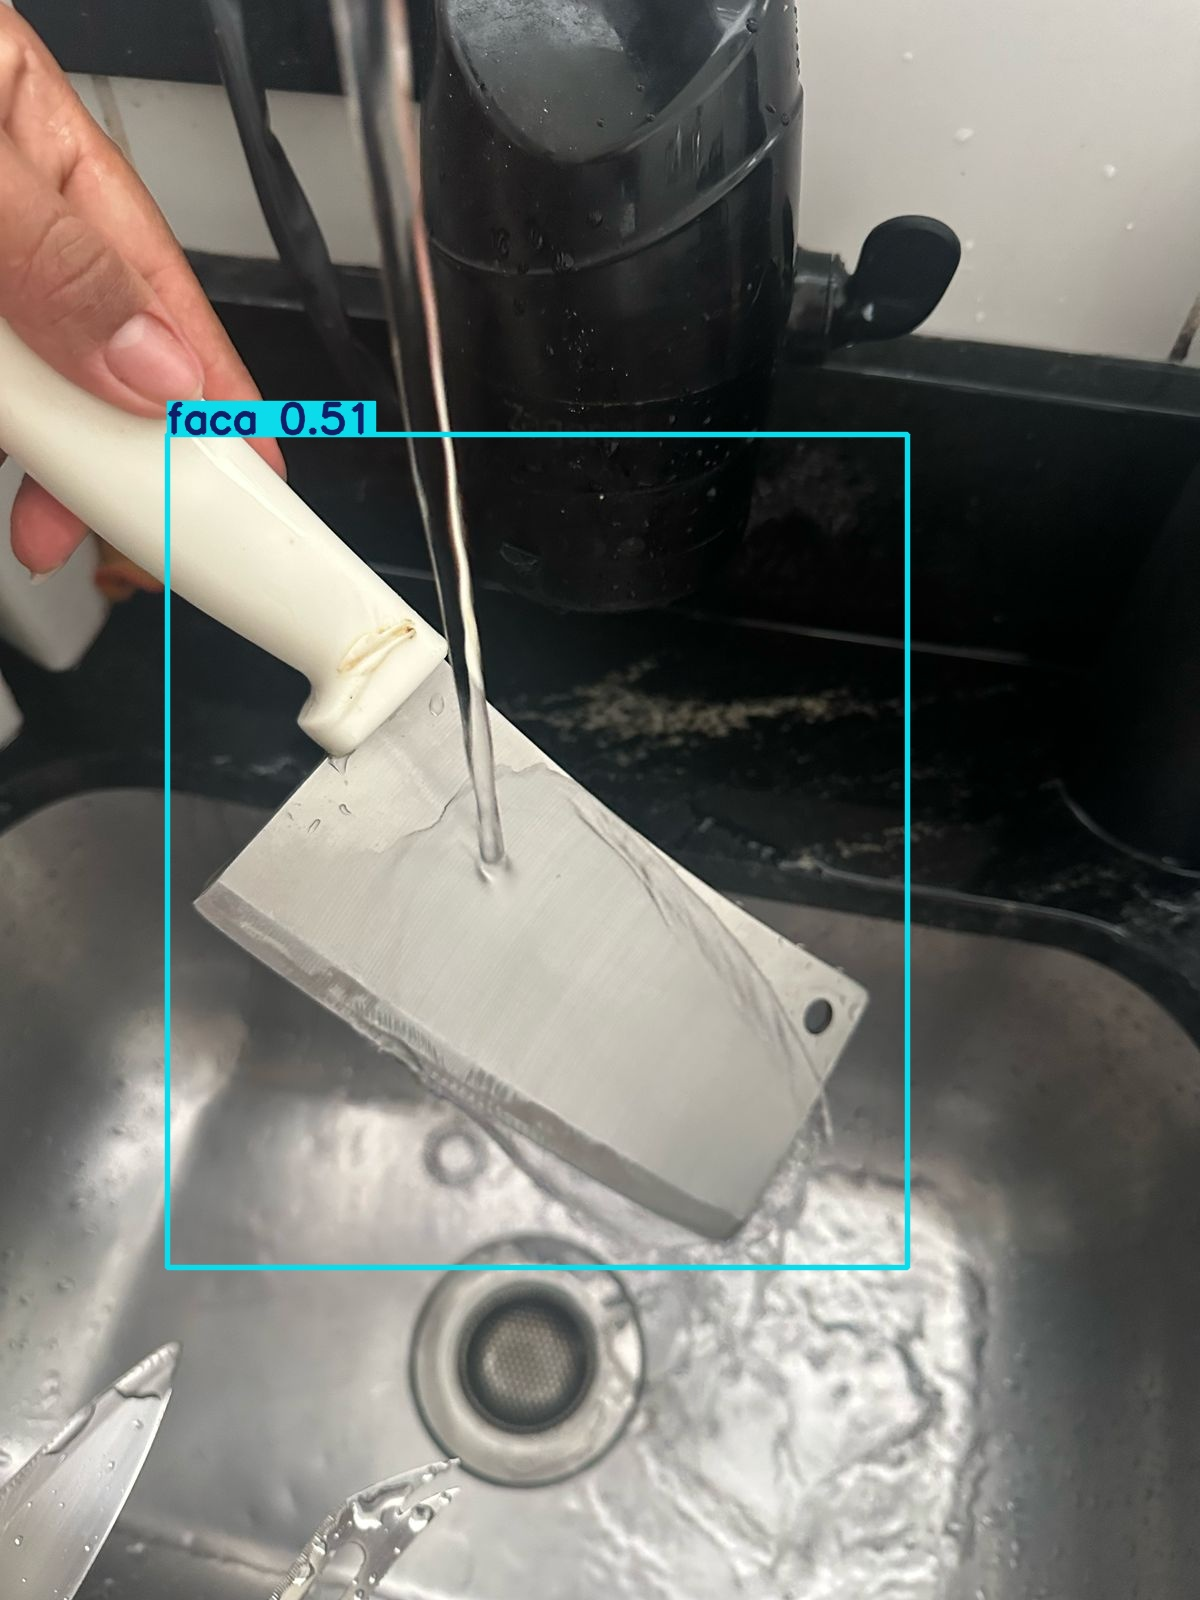

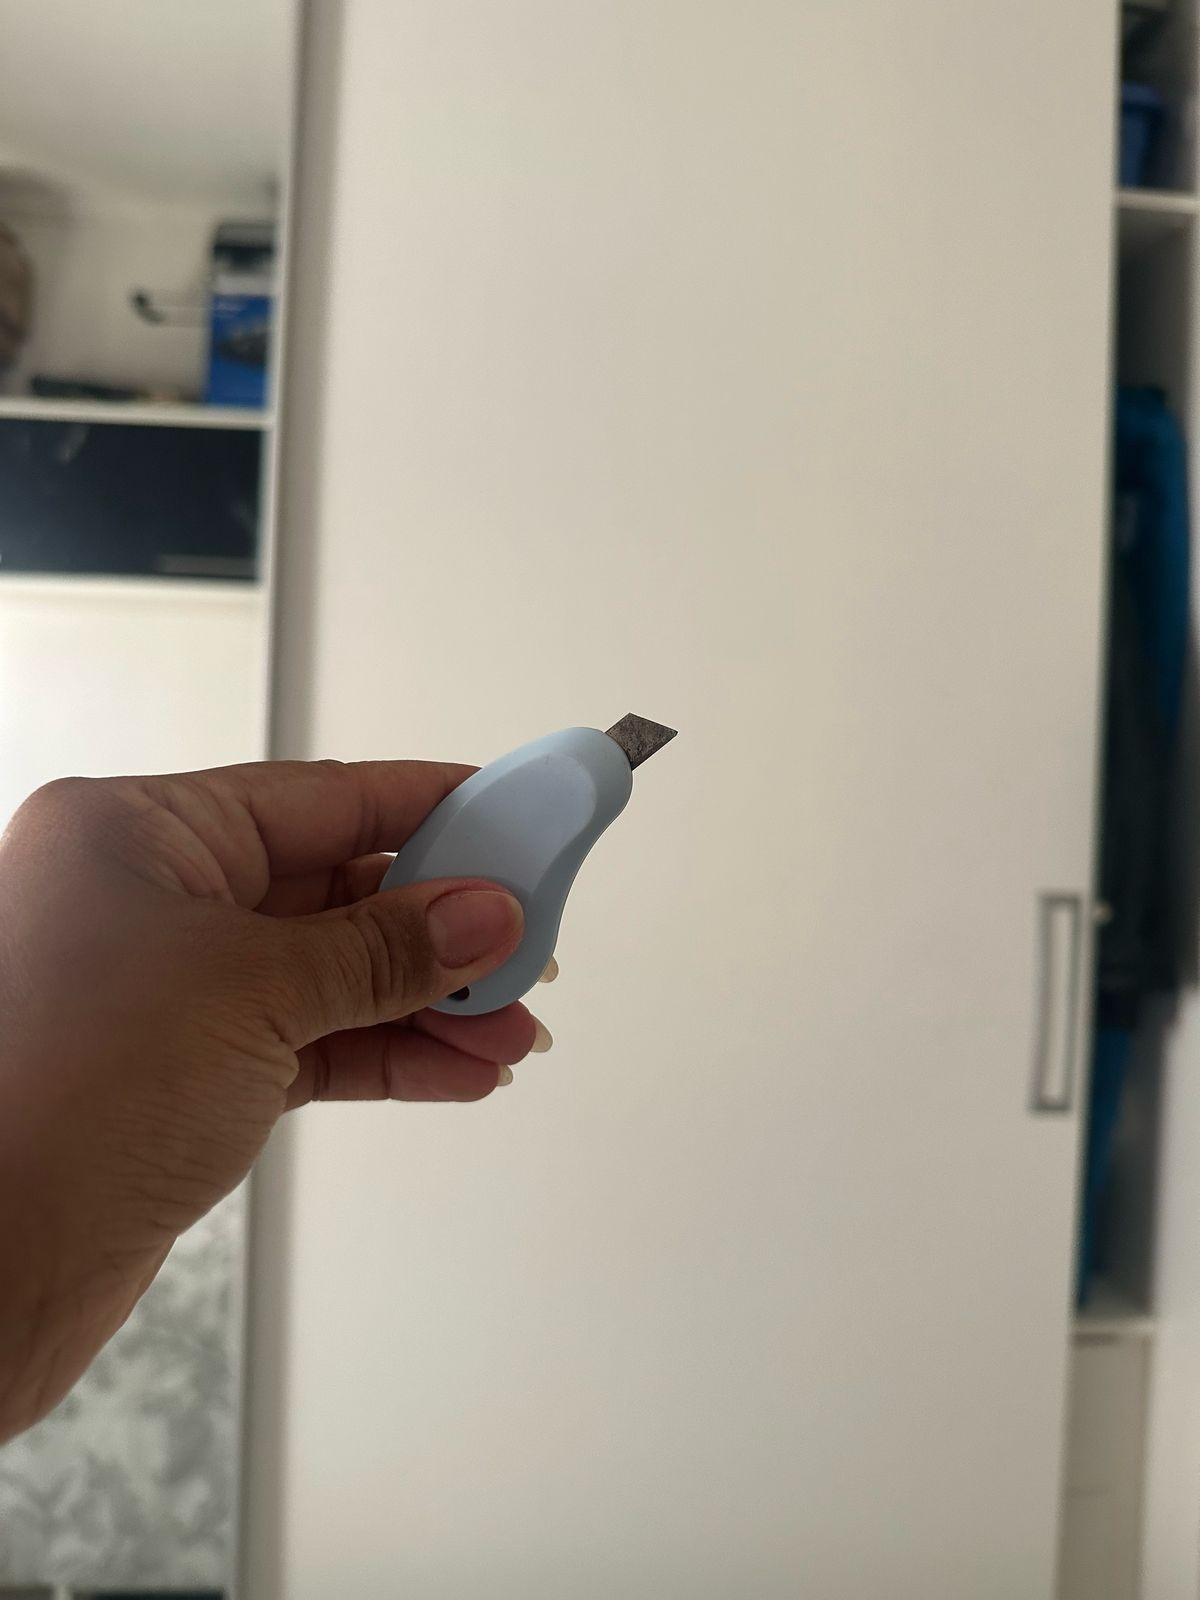

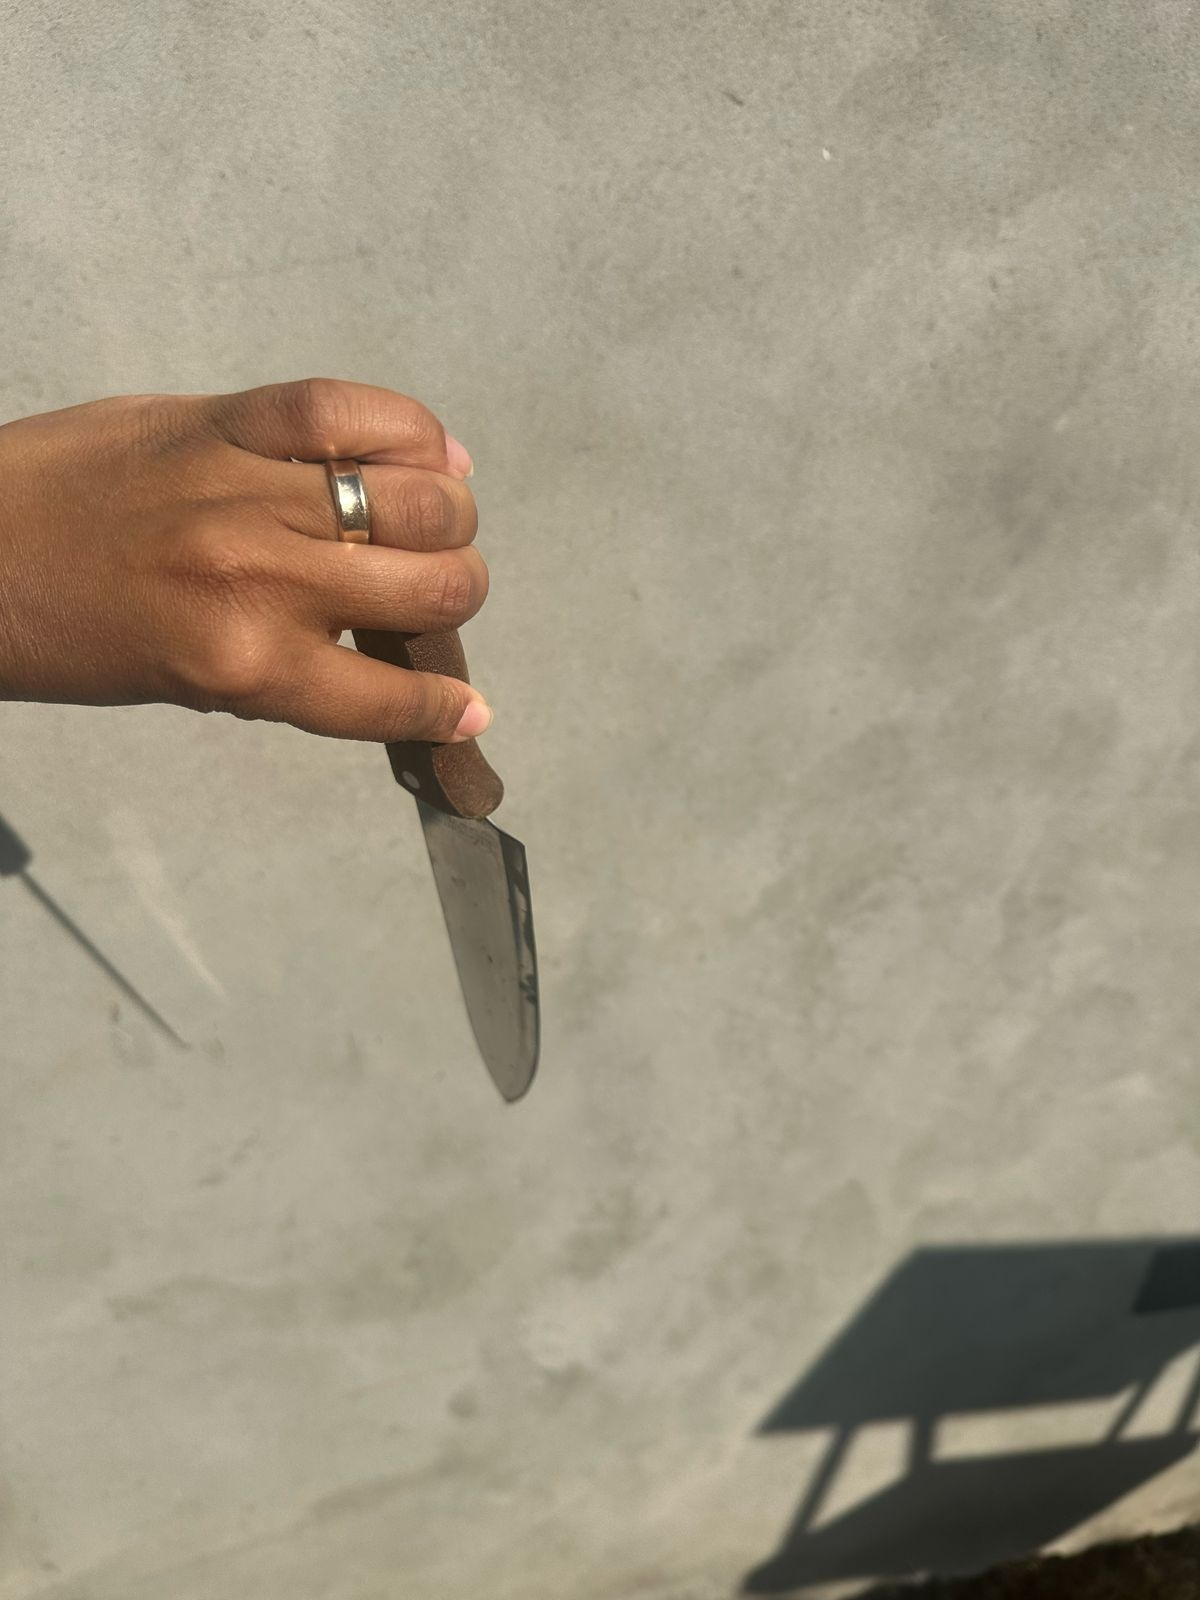

In [47]:
import glob
from IPython.display import Image, display
for image_path in glob.glob(f'./runs/detect/predict/*.jpg')[:10]:
  display(Image(filename=image_path, height=400))
  print('\n')

# Realizar o envio de e-mail
Aqui teremos a demosntração do envio de e-mail, o código é simples e utiliza o smtp para isso, com um redimensionamento das imagens para não termos problemas com os anexos

In [50]:
from PIL import Image
import smtplib
from email.mime.multipart import MIMEMultipart
from email.mime.text import MIMEText
from email.mime.base import MIMEBase
from email import encoders

def resize_image(image_path, max_size=(800, 800)):
    with Image.open(image_path) as img:
        img.thumbnail(max_size)
        resized_path = f'resized_{os.path.basename(image_path)}'
        img.save(resized_path)
        return resized_path

async def send_email(subject, body, to_email, image_paths):
    print('Sending email...')
    # Cria a mensagem do e-mail
    msg = MIMEMultipart()
    from_email = os.getenv('email')
    print(from_email)
    from_password = os.getenv('password')

    # Cria a mensagem do e-mail
    msg = MIMEMultipart()
    msg['From'] = from_email
    msg['To'] = to_email
    msg['Subject'] = subject

    # Anexa o corpo do e-mail
    msg.attach(MIMEText(body, 'plain'))

    # Redimensiona e anexa as imagens
    for image_path in image_paths:
        resized_image_path = resize_image(image_path)
        with open(resized_image_path, 'rb') as attachment:
            part = MIMEBase('application', 'octet-stream')
            part.set_payload(attachment.read())
            encoders.encode_base64(part)
            part.add_header('Content-Disposition', f'attachment; filename={os.path.basename(resized_image_path)}')
            msg.attach(part)
        os.remove(resized_image_path)  # Remove a imagem redimensionada após anexá-la

    # Envia o e-mail
    server = smtplib.SMTP('smtp.gmail.com', 587)
    server.starttls()
    server.login(from_email, from_password)
    text = msg.as_string()
    server.sendmail(from_email, to_email, text)
    print('E-mail enviado com sucesso!')
    server.quit()

# Análise de objetos cortantes
Para a análise de objetos cortantes podemos avaliar, imagens, pastas, vídeos ou uma camera no usb.

Em tempo de execução validamos os frames com o modelo treinado, e em caso de mais de 5 objetos identificados, sendo falso positivo ou não, enviamos as imagens para análise.

In [54]:
import nest_asyncio
import asyncio

from datetime import datetime
import os
import sys
import glob
import time
import uuid

import cv2
import numpy as np
from ultralytics import YOLO

# Permite a execução de um loop de eventos dentro de outro
nest_asyncio.apply()

def detect_objects(model, source, thresh, resolution, record):
    # Parse user inputs
    model_path = model
    img_source = source
    min_thresh = thresh
    user_res = resolution
    record = record
    objects_total = 0
    informacoes = []
    imagens = []

    # Verifica se o arquivo do modelo existe e e valido
    if not os.path.exists(model_path):
        print('ERROR: Model path is invalid or model was not found. Make sure the model filename was entered correctly.')
        sys.exit(0)

    # Carrega o modelo na memoria e obtem o labemap
    model = YOLO(model_path, task='detect')
    labels = model.names

    # Analisa a entrada para determinar se a fonte da imagem e um arquivo, pasta, video ou camera USB
    img_ext_list = ['.jpg','.JPG','.jpeg','.JPEG','.png','.PNG','.bmp','.BMP']
    vid_ext_list = ['.avi','.mov','.mp4','.mkv','.wmv']

    if os.path.isdir(img_source):
        source_type = 'folder'
    elif os.path.isfile(img_source):
        _, ext = os.path.splitext(img_source)
        if ext in img_ext_list:
            source_type = 'image'
        elif ext in vid_ext_list:
            source_type = 'video'
        else:
            print(f'File extension {ext} is not supported.')
            sys.exit(0)
    elif 'usb' in img_source:
        source_type = 'usb'
        usb_idx = int(img_source[3:])
    else:
        print(f'Input {img_source} is invalid. Please try again.')
        sys.exit(0)

    # Analisa a resolucao de exibicao especificada pelo usuario
    resize = False
    if user_res:
        resize = True
        resW, resH = int(user_res.split('x')[0]), int(user_res.split('x')[1])

    # Verifica se a gravacao e valida e configura a gravacao
    if record:
        if source_type not in ['video','usb']:
            print('Recording only works for video and camera sources. Please try again.')
            sys.exit(0)
        if not user_res:
            print('Please specify resolution to record video at.')
            sys.exit(0)

        # Configura a gravacao
        record_name =  f'{uuid.uuid4()}.avi'
        record_fps = 30
        recorder = cv2.VideoWriter(record_name, cv2.VideoWriter_fourcc(*'MJPG'), record_fps, (resW,resH))

    # Carrega ou inicializa a fonte da imagem
    if source_type == 'image':
        imgs_list = [img_source]
    elif source_type == 'folder':
        imgs_list = []
        filelist = glob.glob(img_source + '/*')
        for file in filelist:
            _, file_ext = os.path.splitext(file)
            if file_ext in img_ext_list:
                imgs_list.append(file)
    elif source_type == 'video' or source_type == 'usb':

        if source_type == 'video': cap_arg = img_source
        elif source_type == 'usb': cap_arg = usb_idx
        cap = cv2.VideoCapture(cap_arg)

        # Define a resolucao da camera ou vídeo se especificada pelo usuario
        if user_res:
            ret = cap.set(3, resW)
            ret = cap.set(4, resH)

    # Define as cores das caixas delimitadoras (usando o esquema de cores Tableu 10)
    bbox_colors = [(164,120,87), (68,148,228), (93,97,209), (178,182,133), (88,159,106),
                  (96,202,231), (159,124,168), (169,162,241), (98,118,150), (172,176,184)]

    # Inicializa variaveis de controle e status
    avg_frame_rate = 0
    frame_rate_buffer = []
    img_count = 0

    frame_count = 0
    filter_frames = []
    prev_frame = None
    last_execution_time = None

    # Inicia o loop de inferencia
    while True:

        t_start = time.perf_counter()

        # Carrega o frame da fonte da imagem
        if source_type == 'image' or source_type == 'folder': # Se a fonte for imagem ou pasta de imagens, carrega a imagem usando seu nome de arquivo
            if img_count >= len(imgs_list):
                print('Todas as imagens foram processadas. Saindo do programa.')
                sys.exit(0)
            img_filename = imgs_list[img_count]
            frame = cv2.imread(img_filename)
            img_count = img_count + 1

        elif source_type == 'video': # Se a fonte for um video, carrega o proximo frame do arquivo de vídeo
            ret, frame = cap.read()
            if not ret:
                print('Alcancou o final do arquivo de video. Saindo do programa.')
                break

        elif source_type == 'usb': # Se a fonte for uma camera USB, captura o frame da camera
            ret, frame = cap.read()
            if (frame is None) or (not ret):
                print('Nao foi possivel ler os frames da camera. Isso indica que a camera esta desconectada ou nao esta funcionando. Saindo do programa.')
                break

        # Redimensiona o frame para a resolucao de exibicao desejada
        if resize:
            frame = cv2.resize(frame,(resW,resH))

        # Executa a inferencia no frame
        results = model(frame, verbose=False)

        # Extrai os resultados
        detections = results[0].boxes

        # Inicializa a variavel para o exemplo basico de contagem de objetos
        object_count = 0

        # Percorre cada detecção e obtém as coordenadas da bbox, confianca e classe
        for i in range(len(detections)):

            # Obtem as coordenadas da caixa delimitadora
            # Ultralytics retorna resultados em formato Tensor, que precisam ser convertidos para um array Python regular
            xyxy_tensor = detections[i].xyxy.cpu() # Deteccoes em formato Tensor na memoria da CPU
            xyxy = xyxy_tensor.numpy().squeeze() # Converte tensores para array Numpy
            xmin, ymin, xmax, ymax = xyxy.astype(int) # Extrai coordenadas individuais e converte para int

            # Obtem o ID da classe da caixa delimitadora e o nome
            classidx = int(detections[i].cls.item())
            classname = labels[classidx]

            # Obtem a confiança da caixa delimitadora
            conf = detections[i].conf.item()

            passou = True

            #Controle para verificar se os frames são exatamente iguais
            if prev_frame is None:
                filter_frames.append(frame)
            else:
                diff = cv2.absdiff(prev_frame, frame)
                non_zero_count = np.count_nonzero(diff)
                total_pixels = diff.size
                similarity = 1 - (non_zero_count / total_pixels)
                #print(f"Similaridade: {similarity}")
                if similarity < 0.20:
                    filter_frames.append(frame)

                    nome_pasta = "./frames"
                    if not os.path.exists(nome_pasta):
                        os.makedirs(nome_pasta)
                        print(f"Pasta '{nome_pasta}' criada com sucesso!")

                    #cv2.imwrite(f'./frames/{frame_count + 1}.png', frame)
                else:
                    passou = False
            frame_count += 1
            prev_frame = frame

            if passou:
                # Se os frames forem diferentes ai sim faz a verificacao de objetos cortantes
                if conf > float(min_thresh):

                    color = bbox_colors[classidx % 10]
                    cv2.rectangle(frame, (xmin,ymin), (xmax,ymax), color, 2)

                    label = f'{classname}: {int(conf*100)}%'
                    labelSize, baseLine = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1) # recupera tamanho da fonte
                    label_ymin = max(ymin, labelSize[1] + 10) # Nao deixa a marcacao pegar o topo da tela
                    cv2.rectangle(frame, (xmin, label_ymin-labelSize[1]-10), (xmin+labelSize[0], label_ymin+baseLine-10), color, cv2.FILLED) # Draw white box to put label text in
                    cv2.putText(frame, label, (xmin, label_ymin-7), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1) # Draw label text


                    # Salva a imagem com o objeto detectado se for diferente do último frame salvo
                    timestamp = frame_count / record_fps if record else frame_count / avg_frame_rate
                    cv2.imwrite(f'./frames/detected_{classname}_{frame_count}.png', frame)
                    print(f'Objeto {classname} detectado no tempo {timestamp:.2f} segundos')
                    informacoes.append(f'Objeto {classname} detectado no tempo {timestamp:.2f} segundos')
                    imagens.append(f'./frames/detected_{classname}_{frame_count}.png')


                    # Basic example: count the number of objects in the image
                    object_count = object_count + 1
                    objects_total += object_count

        # Calculate and draw framerate (if using video, USB, or Picamera source)
        if source_type == 'video' or source_type == 'usb':
            cv2.putText(frame, f'FPS: {avg_frame_rate:0.2f}', (10,20), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,255), 2) # Draw framerate

        # Display detection results
        cv2.putText(frame, f'Number of objects: {object_count}', (10,40), cv2.FONT_HERSHEY_SIMPLEX, .7, (0,255,255), 2) # Draw total number of detected objects
        cv2.imshow('YOLO detection results',frame) # Display image
        if record: recorder.write(frame)

        # Se estiver fazendo a inferenca em imagens individuais espera o comando se nao espera 5 segundos.
        if source_type == 'image' or source_type == 'folder':
            key = cv2.waitKey()
        elif source_type == 'video' or source_type == 'usb':
            key = cv2.waitKey(5)

        if key == ord('q') or key == ord('Q'): # pressione 'q' para quitar
            break
        elif key == ord('s') or key == ord('S'): # pressione 's' para pausar
            cv2.waitKey()
        elif key == ord('p') or key == ord('P'): # pressione 'p' para salvar um print desse frame
            cv2.imwrite('capture.png',frame)

        # Calcula o FPS do Frame
        t_stop = time.perf_counter()
        frame_rate_buffer.append(float(1/(t_stop - t_start)))

        # Calculate a media do FPS
        avg_frame_rate = np.mean(frame_rate_buffer)

        if objects_total > 5:
            agora = datetime.now()
            if last_execution_time is None or (agora - last_execution_time).total_seconds() > 300: # 300 segundos = 5 minutos
                last_execution_time = agora
                asyncio.create_task(send_email('Detecção de Objeto', '\n'.join(informacoes), 'hackathonrecebe@gmail.com', imagens))

    # Clean up
    print(f'Average pipeline FPS: {avg_frame_rate:.2f}')
    if source_type == 'video' or source_type == 'usb':
        cap.release()
    if record: recorder.release()
    cv2.destroyAllWindows()

In [55]:
# Exemplo de uso
video_path = "./videos/video.mp4"
model_path = "./runs/detect/train/weights/best.pt"

detect_objects(model_path, video_path, 0.5, "1920x1080", True)


Pasta './frames' criada com sucesso!
Objeto faca detectado no tempo 0.10 segundos
Objeto faca detectado no tempo 0.13 segundos
Objeto faca detectado no tempo 0.33 segundos
Objeto faca detectado no tempo 0.87 segundos
Objeto tesoura detectado no tempo 2.03 segundos
Objeto tesoura detectado no tempo 9.47 segundos
Alcancou o final do arquivo de video. Saindo do programa.
Average pipeline FPS: 28.46
